# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


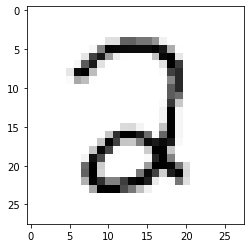

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2434
Training Accuracy: 0.5457, Testing Accuracy: 0.5534



Epoch 10, Loss 0.1259
Training Accuracy: 0.8944, Testing Accuracy: 0.9123



Epoch 20, Loss 0.0687
Training Accuracy: 0.9327, Testing Accuracy: 0.9435



Epoch 30, Loss 0.0497
Training Accuracy: 0.9480, Testing Accuracy: 0.9592



Epoch 40, Loss 0.0413
Training Accuracy: 0.9556, Testing Accuracy: 0.9652



Epoch 50, Loss 0.0367
Training Accuracy: 0.9591, Testing Accuracy: 0.9693



Epoch 60, Loss 0.0338
Training Accuracy: 0.9622, Testing Accuracy: 0.9703



Epoch 70, Loss 0.0317
Training Accuracy: 0.9640, Testing Accuracy: 0.9708



Epoch 80, Loss 0.0301
Training Accuracy: 0.9653, Testing Accuracy: 0.9718



Epoch 90, Loss 0.0288
Training Accuracy: 0.9666, Testing Accuracy: 0.9743



Epoch 100, Loss 0.0277
Training Accuracy: 0.9680, Testing Accuracy: 0.9728



Epoch 110, Loss 0.0268
Training Accuracy: 0.9690, Testing Accuracy: 0.9723



Epoch 120, Loss 0.026
Training Accuracy: 0.9701, Testing Accuracy: 0.9743



Epoch 130, Loss 0.0253
Training Accuracy: 0.9713, Testing Accuracy: 0.9743



Epoch 140, Loss 0.0247
Training Accuracy: 0.9716, Testing Accuracy: 0.9733



Epoch 150, Loss 0.0241
Training Accuracy: 0.9723, Testing Accuracy: 0.9733



Epoch 160, Loss 0.0236
Training Accuracy: 0.9729, Testing Accuracy: 0.9728



Epoch 170, Loss 0.0232
Training Accuracy: 0.9736, Testing Accuracy: 0.9738



Epoch 180, Loss 0.0227
Training Accuracy: 0.9742, Testing Accuracy: 0.9733



Epoch 190, Loss 0.0223
Training Accuracy: 0.9750, Testing Accuracy: 0.9738



Epoch 200, Loss 0.0219
Training Accuracy: 0.9758, Testing Accuracy: 0.9738



Epoch 210, Loss 0.0215
Training Accuracy: 0.9761, Testing Accuracy: 0.9738



Epoch 220, Loss 0.0212
Training Accuracy: 0.9763, Testing Accuracy: 0.9733



Epoch 230, Loss 0.0209
Training Accuracy: 0.9765, Testing Accuracy: 0.9733



Epoch 240, Loss 0.0205
Training Accuracy: 0.9768, Testing Accuracy: 0.9733



0.011265991472945141

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2305
Training Accuracy: 0.7389, Testing Accuracy: 0.7263



Epoch 10, Loss 0.1026
Training Accuracy: 0.9122, Testing Accuracy: 0.9234



Epoch 20, Loss 0.0789
Training Accuracy: 0.9304, Testing Accuracy: 0.9425



Epoch 30, Loss 0.0681
Training Accuracy: 0.9377, Testing Accuracy: 0.9501



Epoch 40, Loss 0.0616
Training Accuracy: 0.9419, Testing Accuracy: 0.9521



Epoch 50, Loss 0.0571
Training Accuracy: 0.9454, Testing Accuracy: 0.9546



Epoch 60, Loss 0.0539
Training Accuracy: 0.9476, Testing Accuracy: 0.9577



Epoch 70, Loss 0.0513
Training Accuracy: 0.9485, Testing Accuracy: 0.9582



Epoch 80, Loss 0.0493
Training Accuracy: 0.9504, Testing Accuracy: 0.9572



Epoch 90, Loss 0.0476
Training Accuracy: 0.9525, Testing Accuracy: 0.9592



Epoch 100, Loss 0.0462
Training Accuracy: 0.9538, Testing Accuracy: 0.9607



Epoch 110, Loss 0.0449
Training Accuracy: 0.9545, Testing Accuracy: 0.9627



Epoch 120, Loss 0.0439
Training Accuracy: 0.9554, Testing Accuracy: 0.9647



Epoch 130, Loss 0.0429
Training Accuracy: 0.9561, Testing Accuracy: 0.9642



Epoch 140, Loss 0.0421
Training Accuracy: 0.9567, Testing Accuracy: 0.9657



Epoch 150, Loss 0.0414
Training Accuracy: 0.9571, Testing Accuracy: 0.9657



Epoch 160, Loss 0.0407
Training Accuracy: 0.9574, Testing Accuracy: 0.9657



Epoch 170, Loss 0.0401
Training Accuracy: 0.9583, Testing Accuracy: 0.9662



Epoch 180, Loss 0.0395
Training Accuracy: 0.9587, Testing Accuracy: 0.9667



Epoch 190, Loss 0.039
Training Accuracy: 0.9592, Testing Accuracy: 0.9657



Epoch 200, Loss 0.0385
Training Accuracy: 0.9593, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0381
Training Accuracy: 0.9596, Testing Accuracy: 0.9662



Epoch 220, Loss 0.0376
Training Accuracy: 0.9601, Testing Accuracy: 0.9662



Epoch 230, Loss 0.0373
Training Accuracy: 0.9603, Testing Accuracy: 0.9662



Epoch 240, Loss 0.0369
Training Accuracy: 0.9604, Testing Accuracy: 0.9662



0.025856320117537822

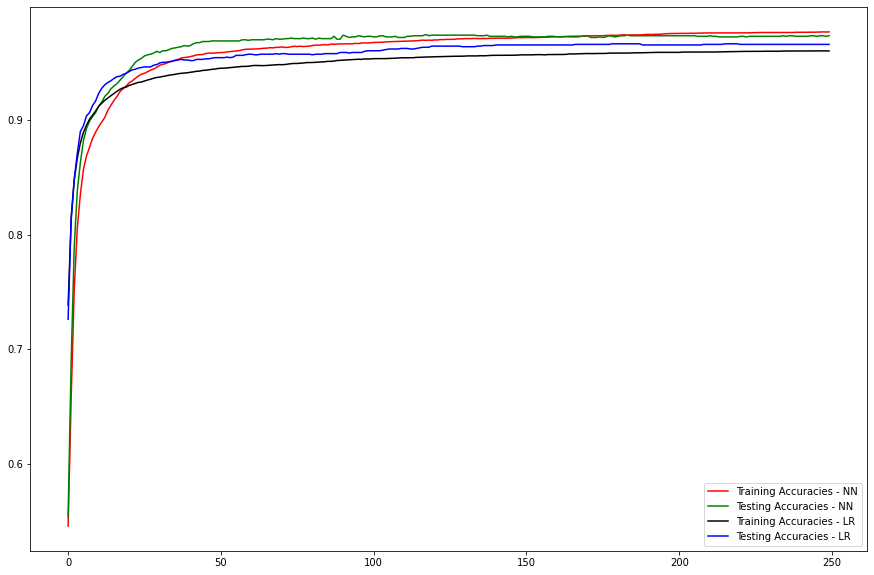

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

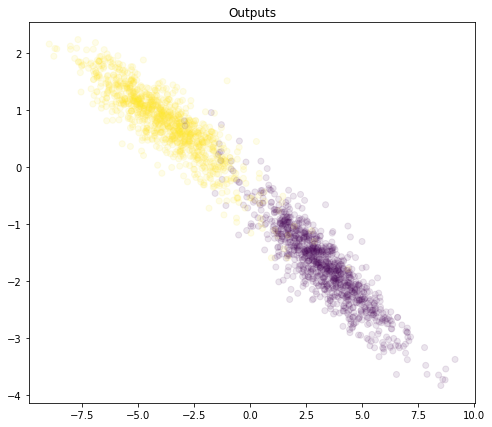

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

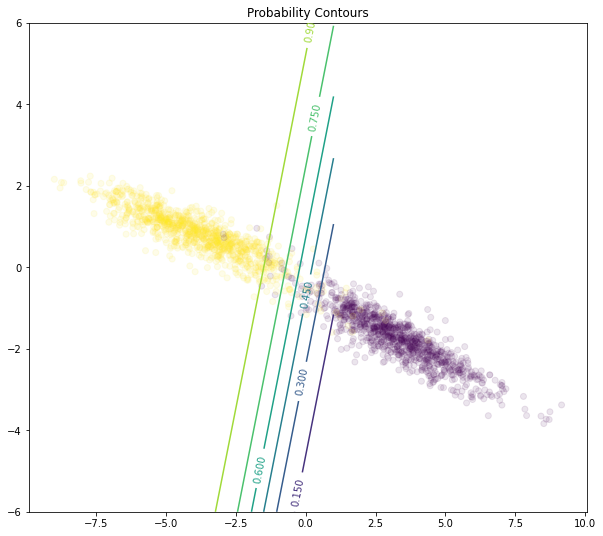

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );